# Fast Fourier Transforms in Pytorch

In the latest pytorch update (1.8), you can now use the torch framework to do Fast Fourier Transforms (fft) in a more optimised and faster way than numpy, and even do the calculations on the GPU!

This really opens up the application of more domain specific augmentations to geophysical deep learning, as previously (in my experience), if you wanted to implement specific geophysical transformations/augmentations while training a deep learning model, there was a massive performance hit. While most people who would want to do transformations like vertical derivatives, upward continuations and filters wont find a use for this, for the use cases when you want to apply these filters at a rate of >1000/min (machine learning), this is really beneficial.

In this notebook I'll quickly show how to use pytorch to do upward continuations on TMI VRTP survey data from South Australia and what the performance increase is compared to the numpy library.

First up - lets load the TMI VRTP raster of the chosen region of SA - Mount Woods. I have regridded the latest GCAS merge to be 40metres per pixel.



Text(0.5, 1.0, 'TMI VRTP Grid of Mount Woods - GCAS')

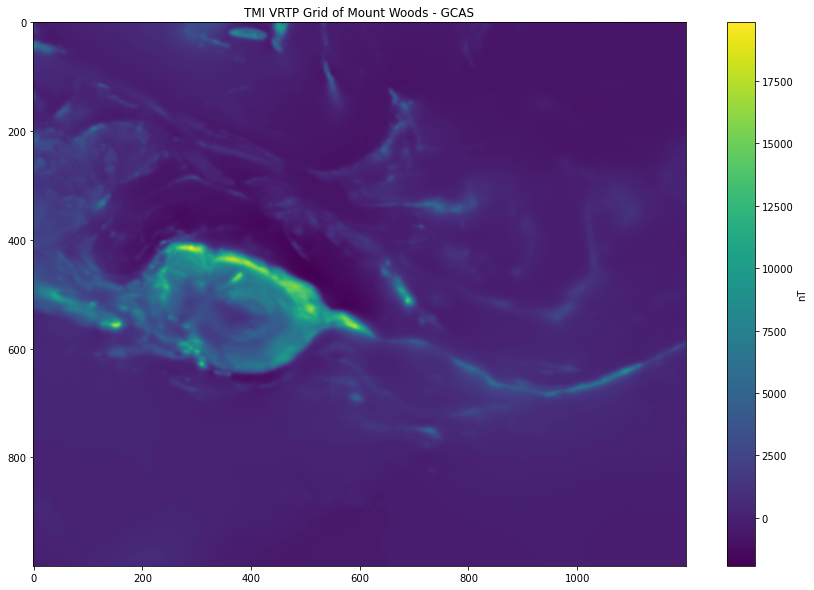

In [2]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mountwoods_vrtp = np.load('mount_woods_vrtp.npy')
spacing = 40 #metres per pixel
plt.subplots(figsize = (15,10))
plt.imshow(mountwoods_vrtp)
cbar = plt.colorbar()
cbar.set_label('nT')
plt.title('TMI VRTP Grid of Mount Woods - GCAS')


So our use case is to apply rapid geophysical transformations on batches of aero-magnetic survey data.

For this experiment, lets just grab lots of random slices of magnetic data from our grid data of the mount woods regions. This is to simulate how training a deep learning model would look like - fast iterations through batches of data.

We want to grab random slices/patches from the raster of size image_width and then grab a little bit more to remove any edge effects that can occur on the borders of the magnetic data once a filter has been applied.

In [3]:
from random import randint
buffer = 100 #100 pixels

def get_batch(n_samples, image_width, buffer):
    """
    Retrieve a batch of slices of survey data from the raster

    n_samples: number of samples in the batch
    image_width: width/height of the slice of survey data (in pixels)
    buffer: extra padding of survey to avoid any edge effects. In this case, we just take an even bigger slice of survey data and remove the buffer once filters have been applied

    """
    batch = []
    halfwidth = image_width//2 + buffer

    min_point_y = halfwidth
    max_point_y = mountwoods_vrtp.shape[0] - halfwidth
    min_point_x = halfwidth
    max_point_x = mountwoods_vrtp.shape[1] - halfwidth

    for i in range(n_samples):
        mid_point_y = randint(min_point_y, max_point_y)
        mid_point_x = randint(min_point_x, max_point_x)
        mag_slice = mountwoods_vrtp[mid_point_y - halfwidth:mid_point_y+halfwidth , mid_point_x - halfwidth : mid_point_x + halfwidth]
        batch.append(mag_slice)
    batch = np.array(batch)

    return batch

batch = get_batch(64, image_width=512, buffer = buffer)


# Implementation

Now lets implement upward continuation using numpy and pytorch.

This is heavily based on the old fatiando implementation (https://github.com/fatiando/fatiando/), with the removal of padding (I prefer to have manual control over it) and the addition of batch support.

To change to pytorch, you simply have to replace numpy with torch, convert the numpy array to a torch tensor and add  device variable for fftfreqs if you want to use the GPU. Its that simple!


In [4]:
import torch

def upward_cont_batch(mag_batch, spacing, upward_amount):
    """
    Upward continue the magnetic data using numpy. 

    mag_batch: Batch of magnetic grid data to upward contine of format (N,H,W)
    spacing: distance per pixel (eg each pixel represents 40m)
    upward_amount: height increase

    Modified from fatiando repo
    Oliveira Jr, V. C., V. C. F. Barbosa, and L. Uieda (2013), Upward Continue, Geophysics, 78(1), G1-G13, doi:10.1190/geo2012-0196.1.

    """

    fx = 2*np.pi*np.fft.fftfreq(mag_batch.shape[1], spacing)
    fy = 2*np.pi*np.fft.fftfreq(mag_batch.shape[2], spacing)
    kx, ky =  np.meshgrid(fy, fx)[::-1]
    kz = np.sqrt(kx**2 + ky**2)

    upcont_ft = np.fft.fft2(mag_batch)*np.exp(-upward_amount*kz)

    cont = np.real(np.fft.ifft2(upcont_ft))

    return cont

def upward_cont_batch_pytorch(mag_batch, spacing, upward_amount, use_gpu):
    """
    Upward continue the magnetic data using pytorch. 

    mag_batch: Batch of magnetic grid data to upward contine of format (N,H,W)
    spacing: distance per pixel (eg each pixel represents 40m)
    upward_amount: height increase
    use_gpu: perform the calculations on the gpu
    """
    

    if use_gpu:
        device = 'cuda:0'
    else:
        device = 'cpu'

    mag_batch = torch.Tensor(mag_batch).to(device)
    fx = 2*np.pi*torch.fft.fftfreq(mag_batch.shape[1], spacing, device = device)
    fy = 2*np.pi*torch.fft.fftfreq(mag_batch.shape[2], spacing, device = device)
    kx, ky =  torch.meshgrid(fy, fx)[::-1]
    kz = torch.sqrt(kx**2 + ky**2)

    upcont_ft = torch.fft.fft2(mag_batch)*torch.exp(-upward_amount*kz)

    cont = torch.real(torch.fft.ifft2(upcont_ft))

    del mag_batch

    return cont.cpu().numpy()


Now lets test that it works and each implementation gives the same answer. Note that I remove the extra buffer zone before plotting.

Text(0.5, 0.98, 'Numpy Implementation')

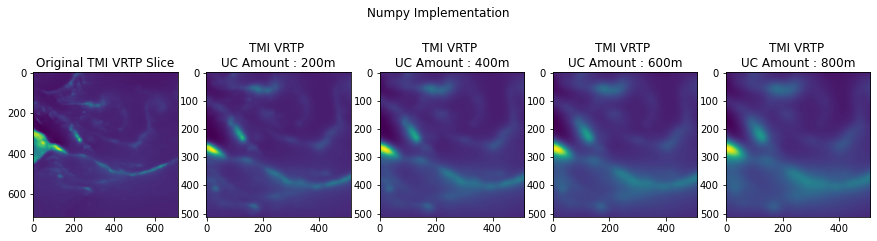

In [5]:
idx = 0
fig,axs = plt.subplots(figsize = (15,4), ncols=5)
axs[0].imshow(batch[idx])
axs[0].set_title("Original TMI VRTP Slice") 
for i, uc_level in enumerate([200,400,600,800]):
    mag_slice_uc = upward_cont_batch(batch, spacing = 40, upward_amount = uc_level)
    axs[i+1].imshow(mag_slice_uc[idx][buffer:-buffer, buffer:-buffer])
    axs[i+1].set_title("TMI VRTP \nUC Amount : {}m".format(uc_level)) 
plt.suptitle('Numpy Implementation')

Text(0.5, 0.98, 'Pytorch Implementation')

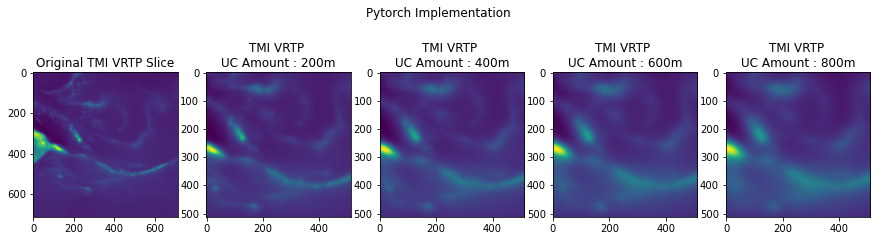

In [6]:
idx = 0
fig,axs = plt.subplots(figsize = (15,4), ncols=5)
axs[0].imshow(batch[idx])
axs[0].set_title("Original TMI VRTP Slice") 
for i, uc_level in enumerate([200,400,600,800]):
    mag_slice_uc = upward_cont_batch_pytorch(batch, spacing = 40, upward_amount = uc_level, use_gpu = False)
    axs[i+1].imshow(mag_slice_uc[idx][buffer:-buffer, buffer:-buffer])
    axs[i+1].set_title("TMI VRTP \nUC Amount : {}m".format(uc_level)) 
plt.suptitle('Pytorch Implementation')

Whats the max variance between the difference implementations? (A quick sanity check to see that pytorch is the same as numpy)

Text(0.5, 1.0, 'Difference Between \nPytorch CPU UC and Pytorch GPU UC')

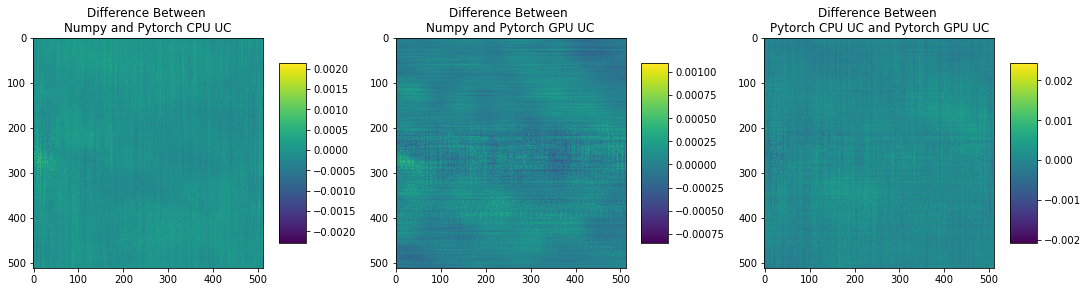

In [7]:
uc_np = upward_cont_batch(batch, spacing = 40, upward_amount = uc_level)[:,buffer:-buffer,buffer:-buffer]
uc_cpu = upward_cont_batch_pytorch(batch, spacing = 40, upward_amount = uc_level, use_gpu = False)[:,buffer:-buffer,buffer:-buffer]
uc_gpu = upward_cont_batch_pytorch(batch, spacing = 40, upward_amount = uc_level, use_gpu = True)[:,buffer:-buffer,buffer:-buffer]

fig,axs = plt.subplots(figsize = (15,5),ncols = 3, constrained_layout = True)

im = axs[0].imshow((uc_np - uc_cpu)[0])
plt.colorbar(im, ax = axs[0], shrink = 0.5)
axs[0].set_title('Difference Between \nNumpy and Pytorch CPU UC')

im = axs[1].imshow((uc_np - uc_gpu)[0])
plt.colorbar(im, ax = axs[1], shrink = 0.5)
axs[1].set_title('Difference Between \nNumpy and Pytorch GPU UC')

im = axs[2].imshow((uc_cpu - uc_gpu)[0])
plt.colorbar(im, ax = axs[2], shrink = 0.5)
axs[2].set_title('Difference Between \nPytorch CPU UC and Pytorch GPU UC')

Okay, so some minor variance between the implementations, but tiny enough compared to other sources of error.

# Performance Benchmarking

Now for the important testing. Whats the speed difference? Lets check this by comparing different batch sizes and image sizes. Rerun the calculation 5 times to get a decent average calculation time.

These benchmarks were done on:

    - CPU: i7 9700k
    
    - GPU: 2080ti

In [8]:
import datetime
results = []
n_tests = 5
for batch_size in [16,64,256]:
    for image_size in [128,256,512]:
        batch = get_batch(n_samples=batch_size, image_width=image_size, buffer=buffer)

        start_time = datetime.datetime.now()
        for i in range(n_tests):
            uc_batch = upward_cont_batch(batch, spacing = 40, upward_amount = 500)
        end_time = datetime.datetime.now()

        results.append({'method' : 'numpy', 'batch_size' : batch_size, 'image_size' : image_size, 'time_taken' : (end_time - start_time) / n_tests})

        start_time = datetime.datetime.now()
        for i in range(n_tests):
            uc_batch = upward_cont_batch_pytorch(batch, spacing = 40, upward_amount = 500, use_gpu=False)
        end_time = datetime.datetime.now()
        results.append({'method' : 'pytorch_cpu', 'batch_size' : batch_size, 'image_size' : image_size, 'time_taken' : (end_time - start_time) / n_tests})

        start_time = datetime.datetime.now()
        for i in range(n_tests):
            uc_batch = upward_cont_batch_pytorch(batch, spacing = 40, upward_amount = 500, use_gpu=True)
        end_time = datetime.datetime.now()
        results.append({'method' : 'pytorch_gpu', 'batch_size' : batch_size, 'image_size' : image_size, 'time_taken' : (end_time - start_time) / n_tests})
results = pd.DataFrame(results)
results['time_taken'] = results.time_taken.dt.total_seconds()

Lets plot the results, showing the time taken for the 3 different methods with differing batch sizes (BS) and image sizes (IS).

Text(0.5, 0.98, 'Performance Benchmarking for different Upward Continue implementations')

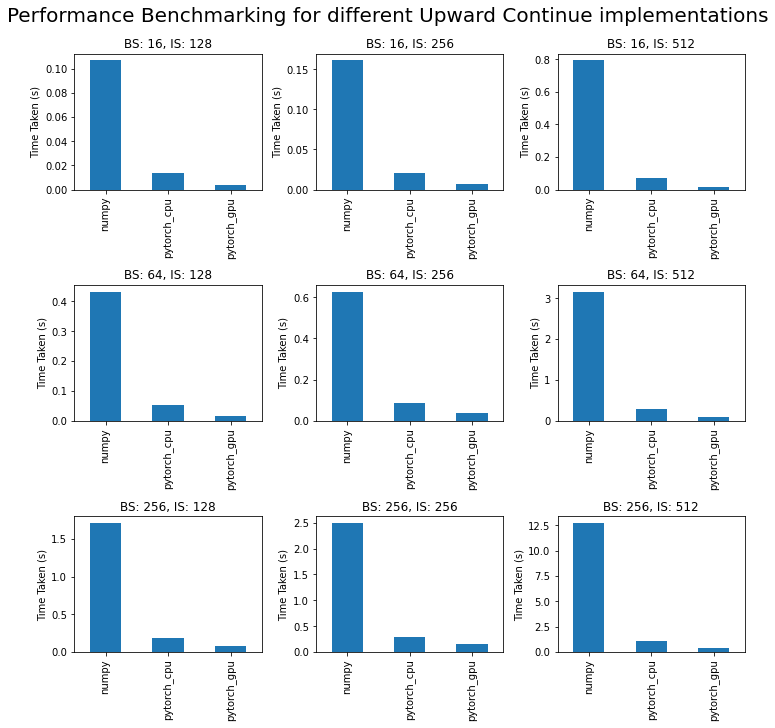

In [9]:
fig,axs = plt.subplots(figsize = (10,10), nrows =3, ncols = 3, constrained_layout = True)
for i, batch_size in enumerate([16,64,256]):
    for j, image_size in enumerate([128,256,512]):
        results[(results.batch_size == batch_size) & (results.image_size == image_size)].plot.bar('method', 'time_taken', ax = axs[i,j], legend = None)
        axs[i,j].set_xlabel(None)
        axs[i,j].set_ylabel('Time Taken (s)')
        axs[i,j].set_title(f'BS: {batch_size}, IS: {image_size}')

plt.suptitle('Performance Benchmarking for different Upward Continue implementations', fontsize = 20)

The results speak for themselves - the new pytorch implementation is very fast compared to the numpy library.

At a batchsize of 256 and image size of 512 pixels, the pytorch cpu implementation is 9.4 times faster than numpy, while the GPU version is 31 times faster than numpy and 3.35 times faster than the CPU version.

When I first started writing this benchmark, my expectation was that the GPU version would blow away any CPU implementation, but that doesn't appear to be the case. It looks like using the pytorch CPU version is good enough to remove any bottlenecks, so implenting custom geophysical transforms in Pytorch's dataloader class will provide huge performance benefits without requiring extra code passing data between GPUs and CPUs.

So in summary, simplying switching out numpy with torch in your code will provide huge performance increases if you are using fast fourier transforms. While this doesn't matter for the one-off calculations that is the standard use cases of these transforms in the exploration industry, the pytorch implementation will be valuable for any use cases in deep learning applications of geophysics.


Thanks for reading! - Michael Rodda

<img src="img/logov2.png" alt="Drawing" style="width: 200px;"/>



Caldera Analytics is a data science consultancy developing modern data science methods to assist explorers looking for IOCG deposits in undercover & difficult areas.


